In [107]:
%run "Data Cleaning.ipynb"

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


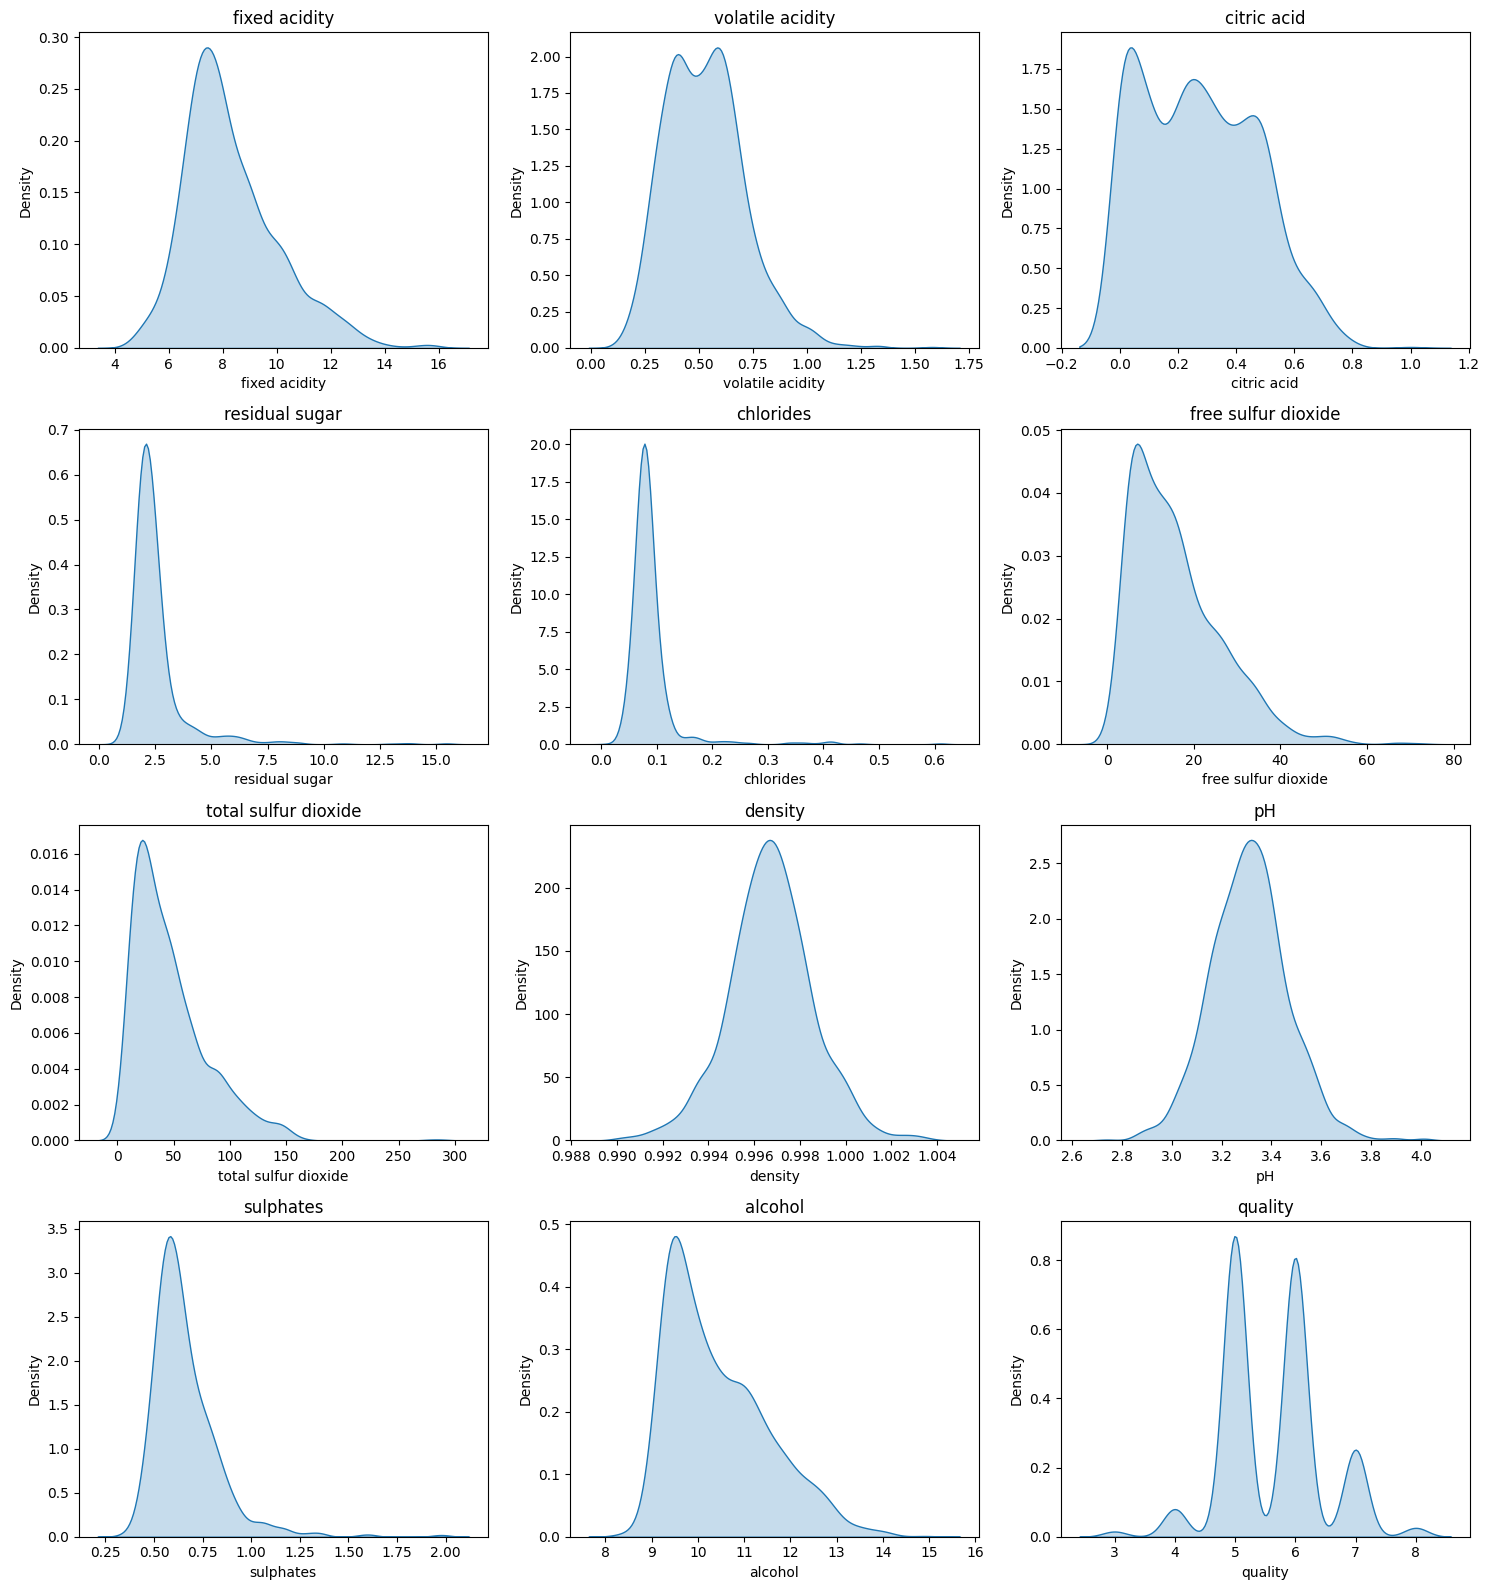

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = df.columns
num_cols = len(numeric_cols)
cols_per_row = 3
rows = (num_cols + cols_per_row - 1) // cols_per_row
plt.figure(figsize=(cols_per_row*5, rows*4))
for i, col in enumerate(numeric_cols):
    plt.subplot(rows,cols_per_row,i+1)
    sns.kdeplot(x=df[col],fill=True)
    plt.title(col)
plt.tight_layout()
plt.show()


In [109]:
import pandas as pd
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [110]:
df['quality'].value_counts()
def map_quality(val):
    if val in [3,4]:
        return 0
    elif val in [5,6]:
        return 1
    else:
        return 2

df['quality_class'] = df['quality'].apply(map_quality)

In [111]:
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
scaler = StandardScaler()
X=df.drop(['quality_class','quality'],axis=1)
y=df['quality_class'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)

model = Sequential([
    Dense(64,input_dim=X_train_bal.shape[1],activation="relu"),
    Dropout(0.2),
    Dense(32,activation="relu"),
    Dense(3,activation="softmax")
])
model.compile(optimizer="adam", loss="crossentropy", metrics=["accuracy"])
early_stop = EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
import pickle
model.save("wine_ann_model.h5")
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("model_columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

Epoch 1/100


c:\Users\kishore\anaconda3\envs\anaconda1\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7464 - loss: 1.5590 - val_accuracy: 0.8462 - val_loss: 0.6467
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7689 - loss: 1.0213 - val_accuracy: 0.8397 - val_loss: 0.5336
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7673 - loss: 0.9012 - val_accuracy: 0.8462 - val_loss: 0.5007
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8202 - loss: 0.6967 - val_accuracy: 0.8462 - val_loss: 0.4892
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8218 - loss: 0.6929 - val_accuracy: 0.8462 - val_loss: 0.4819
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8218 - loss: 0.6266 - val_accuracy: 0.8397 - val_loss: 0.4833
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8074 - loss: 0.6095 - val_accuracy: 0.8462 - val_loss: 0.4867
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8266 - loss: 0.6242 - val_accuracy: 0.8462 - val_loss: 0.

In [112]:
from sklearn.metrics import accuracy_score
print(f'Accuracy:{accuracy_score(y_test, y_pred_classes)}')


Accuracy:0.8307692307692308


Confusion Matrix:
 [[  0   7   0]
 [  0 151  16]
 [  0  10  11]]


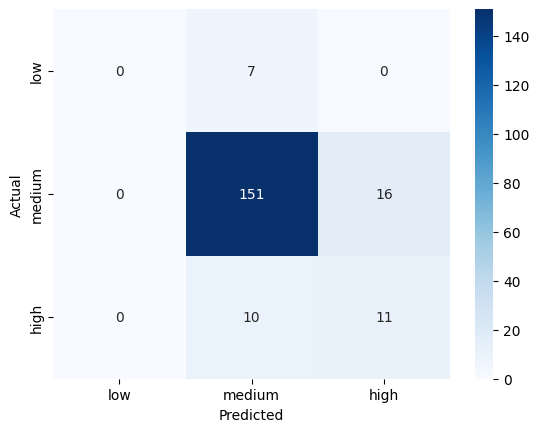

In [113]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_classes)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['low','medium','high'], yticklabels=['low','medium','high'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()